# Exploratory Data Analysis

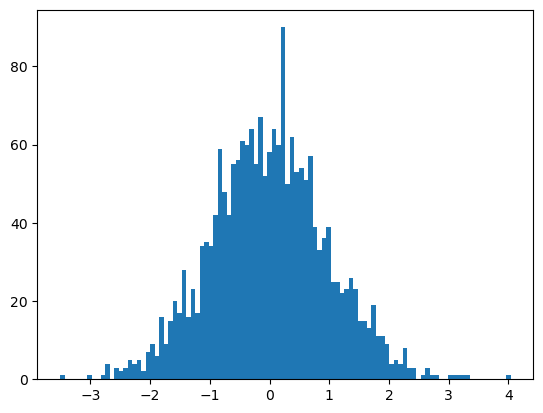

In [8]:
import numpy as np
import matplotlib.pyplot as plt

x = np.random.normal(size=2000)

plt.hist(x,bins=100)
plt.show()